<a href="https://colab.research.google.com/github/ZachLuttrell/UCSD_Capstone/blob/main/Baseline_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training The Baseline:

**ITERATION 2:**
Training the U-Net without the VGG16 backbone, and only training on 20% of the dataset to reduce training times.

Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Install any missing libraries if necessary

In [ ]:
import os
import cv2
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split

Load in the images and their corresponding masks

In [ ]:
import os

def count_files(directory, extension=".tif"):
    # List all files in the directory and count those with the specified extension
    return sum(1 for file in os.listdir(directory) if file.endswith(extension))

# Paths to your image and mask directories
image_directory = '/gdrive/My Drive/Dataset/patches/images/'
mask_directory = '/gdrive/My Drive/Dataset/patches/masks/'

# Counting the TIFF files in both directories
image_count = count_files(image_directory)
mask_count = count_files(mask_directory)

print(f"Number of image files: {image_count}")
print(f"Number of mask files: {mask_count}")


Number of image files: 5632
Number of mask files: 5632


In [ ]:
import os
import numpy as np
import tifffile as tiff

# Set the image and mask directories
image_directory = '/gdrive/My Drive/Dataset/patches/images'
mask_directory = '/gdrive/My Drive/Dataset/patches/masks'

# Load the images and masks into the lists below
images = []
masks = []

# Sort filenames to ensure matching pairs align
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".tif")])
mask_files = sorted([f for f in os.listdir(mask_directory) if f.endswith(".tif")])

# Determine how many files to load based on percentage (e.g., 20%)
percentage_to_load = 20 / 100.0  # size of dataset
number_of_files_to_load = int(len(image_files) * percentage_to_load)

# Create a mapping of image names to their corresponding mask names by removing '_Buildings'
image_to_mask = {f: f.replace("_patch", "_Buildings_patch") for f in image_files}

# Only iterate over the subset of files determined by the percentage
count = 0
for image_name in image_files[:number_of_files_to_load]:
    img_path = os.path.join(image_directory, image_name)
    mask_name = image_to_mask[image_name]
    mask_path = os.path.join(mask_directory, mask_name)

    if os.path.exists(mask_path):
        img = tiff.imread(img_path)
        mask = tiff.imread(mask_path)

        images.append(img)
        masks.append(mask)
    else:
        print(f'Mask not found for image: {image_name}')

    # update the count
    count += 1
    print(f'Processed: {count}')

# Convert the lists to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

# Normalize the values
images /= 255.0
masks /= 255.0
masks = masks.reshape((-1, 256, 256, 1))  # Adjust as per your channel needs

Processed: 1
Processed: 2
Processed: 3
Processed: 4
Processed: 5
Processed: 6
Processed: 7
Processed: 8
Processed: 9
Processed: 10
Processed: 11
Processed: 12
Processed: 13
Processed: 14
Processed: 15
Processed: 16
Processed: 17
Processed: 18
Processed: 19
Processed: 20
Processed: 21
Processed: 22
Processed: 23
Processed: 24
Processed: 25
Processed: 26
Processed: 27
Processed: 28
Processed: 29
Processed: 30
Processed: 31
Processed: 32
Processed: 33
Processed: 34
Processed: 35
Processed: 36
Processed: 37
Processed: 38
Processed: 39
Processed: 40
Processed: 41
Processed: 42
Processed: 43
Processed: 44
Processed: 45
Processed: 46
Processed: 47
Processed: 48
Processed: 49
Processed: 50
Processed: 51
Processed: 52
Processed: 53
Processed: 54
Processed: 55
Processed: 56
Processed: 57
Processed: 58
Processed: 59
Processed: 60
Processed: 61
Processed: 62
Processed: 63
Processed: 64
Processed: 65
Processed: 66
Processed: 67
Processed: 68
Processed: 69
Processed: 70
Processed: 71
Processed: 72
P

Perform the Train/Test/Val Split

In [ ]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=1995)

# Further split the training set into training and validation sets (90% train, 10% val)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1995)

# Show the shapes
print('Dataset Shapes:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_val:   {X_val.shape}')
print(f'y_val:   {y_val.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_test:  {y_test.shape}')

Dataset Shapes:
X_train: (810, 1, 256, 256, 3)
y_train: (810, 256, 256, 1)
X_val:   (90, 1, 256, 256, 3)
y_val:   (90, 256, 256, 1)
X_test:  (226, 1, 256, 256, 3)
y_test:  (226, 256, 256, 1)


In [ ]:
# If X_train, X_test, X_val have an extra unnecessary dimension at axis=1, you can remove it:
X_train = X_train.squeeze(axis=1)
X_test = X_test.squeeze(axis=1)
X_val = X_val.squeeze(axis=1)

Define the Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.backend import epsilon

def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon())

def jaccard_index(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    return (intersection + epsilon()) / (union + epsilon())

def simple_unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


Compile the Model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Create the model
model = simple_unet_model(input_size=(256, 256, 3))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=['accuracy', dice_coefficient, jaccard_index]
)

# Print a summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 256, 256, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 dropout_27 (Dropout)        (None, 256, 256, 64)         0         ['conv2d_57[0][0]']           
                                                                                                  
 conv2d_58 (Conv2D)          (None, 256, 256, 64)         36928     ['dropout_27[0][0]']          
                                                                                            

Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Model Checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1  # Set to 2 for one line per epoch, 1 for a progress bar
)

# Save the Model
model_save_path = '/content/drive/My Drive/Dataset/Models/unet_1.h5'  # Change 'my_model' to your preferred model name
model.save(model_save_path)

print(f"Model saved to {model_save_path}")


# Evaluate The Model

In [ ]:
# Save the Model
model_save_path = '/gdrive/My Drive/Dataset/Models/unet_1.h5'  # Change 'my_model' to your preferred model name
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /gdrive/My Drive/Dataset/Models/unet_1.h5


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon())

def jaccard_index(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    return (intersection + epsilon()) / (union + epsilon())

# Path to your saved model
model_save_path = '/gdrive/My Drive/Dataset/Models/unet_1.h5'

# Load the model with the custom object
model = load_model(model_save_path, custom_objects={'dice_coefficient': dice_coefficient, 'jaccard_index': jaccard_index})

print("Model loaded successfully!")

Model loaded successfully!


1/1 [==============================] - 0s 401ms/step


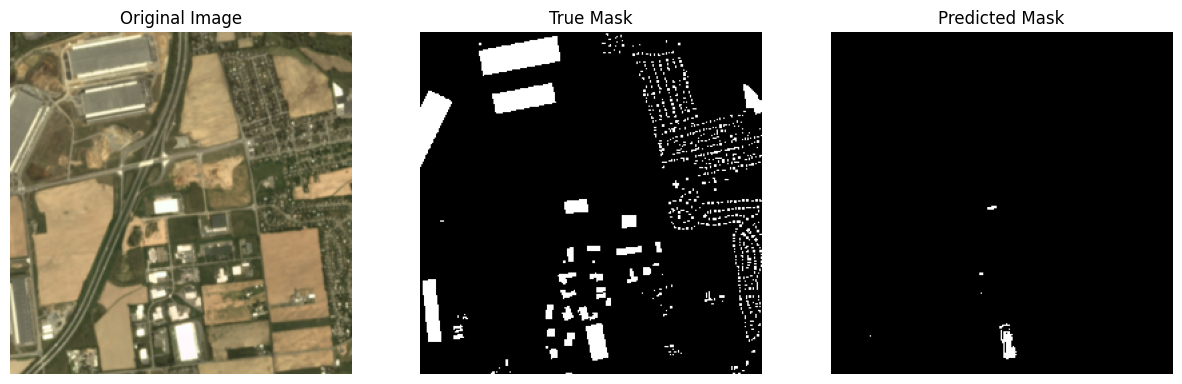

Index No.: 123
1/1 [==============================] - 0s 400ms/step


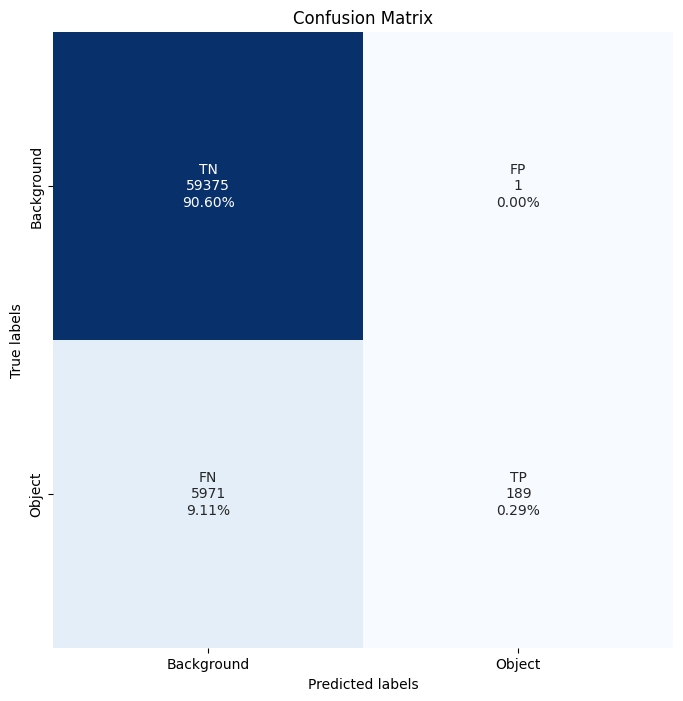

Index No.: 123


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Function to make predictions
def make_prediction(model, image):
    image = np.expand_dims(image, axis=0)  # Expand dims to add the batch size
    pred_mask = model.predict(image)[0]    # Make prediction
    return pred_mask

# Select a random example
index = np.random.randint(0, len(X_test))  # Choose a random index from the test set
sample_image = X_test[index]
sample_mask = y_test[index]

# Get the model prediction
predicted_mask = make_prediction(model, sample_image)

# Post-process the predicted mask
predicted_mask = (predicted_mask > 0.5).astype(np.float32)  # Threshold probabilities to create a binary mask

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_image)
ax[0].title.set_text('Original Image')
ax[0].axis('off')

ax[1].imshow(sample_mask.squeeze(), cmap='gray')  # Assuming mask is single-channel
ax[1].title.set_text('True Mask')
ax[1].axis('off')

ax[2].imshow(predicted_mask.squeeze(), cmap='gray')  # Same as above for the predicted mask
ax[2].title.set_text('Predicted Mask')
ax[2].axis('off')

plt.show()
print(f'Index No.: {index}')

########### SHOW CONFUSION MATRIX
# Prediction and preprocessing as before
def predict_mask(model, image):
    pred = model.predict(np.expand_dims(image, axis=0))
    return (pred > 0.5).astype(np.float32)  # Apply a threshold to convert probabilities to binary mask

# Sample selection

# index = np.random.randint(0, len(X_test))

sample_image = X_test[index]
true_mask = y_test[index].squeeze()

# Get the prediction
pred_mask = predict_mask(model, sample_image).squeeze()

# Flatten arrays for confusion matrix computation
true_mask_flat = true_mask.flatten()
pred_mask_flat = pred_mask.flatten()

# Compute the confusion matrix
cm = confusion_matrix(true_mask_flat, pred_mask_flat, labels=[0, 1])

# Custom annotations
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=labels, fmt='', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Background', 'Object'])
ax.yaxis.set_ticklabels(['Background', 'Object'])
plt.show()
print(f'Index No.: {index}')